Main_Branch Privacy Version

In [1]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda, BatchNormalization
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from scipy.special import rel_entr
from keras.models import load_model

In [2]:
train_data = pd.read_csv(
    "../data/interim/privacy_testing/train_random_sample.csv")
test_data = pd.read_csv("../data/interim/split/sorted_test_data_mm.csv")
# val_data = pd.read_csv("../data/interim/split/sorted_val_data_mm.csv")

In [3]:
train_data_array = train_data.values
# test_data_array = test_data.values
# val_data_array = val_data.values

In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return {}

    @classmethod
    def from_config(cls, config):
        return cls()

In [5]:
latent_dim = 32
encoder_inputs = Input(shape=(31), name="input_layer")

n_x1 = 256
x = Dense(n_x1, activation="relu", name="h1")(encoder_inputs)
x = BatchNormalization(name="batch1")(x)
x = Dense(n_x1, activation="relu", name="h2")(x)

# Split x3 into two halves
half_size = n_x1 // 2
x1_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x)
x1_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x)

z_mean = Dense(latent_dim, name="z_mean")(x1_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x1_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

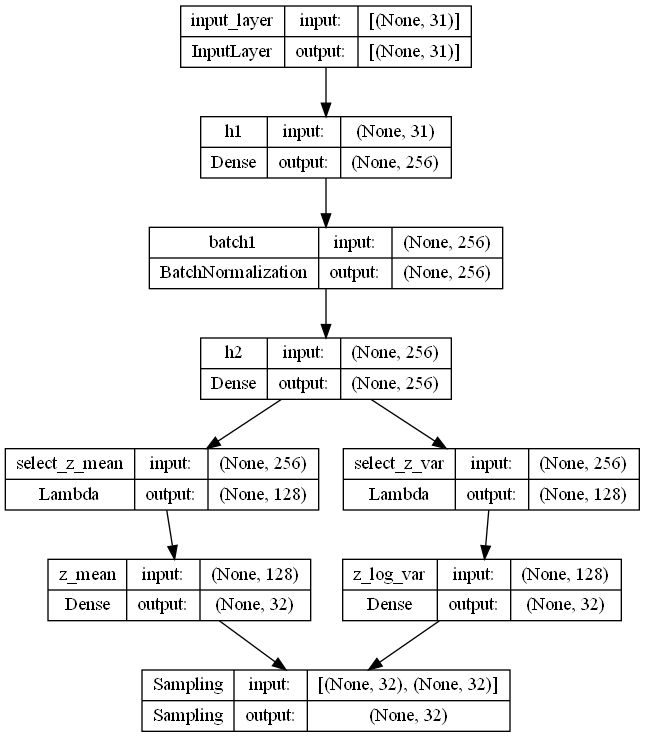

In [6]:
keras.utils.plot_model(encoder, show_shapes=True)

In [7]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x4 = 256
x = Dense(n_x4, activation="relu", name="h4")(latent_inputs)
x = BatchNormalization(name="batch1")(x)
x = Dense(n_x4, activation="relu", name="h5")(x)
cont_decoder_outputs = Dense(30, activation = 'linear', name="cont_decoder_output")(x)
class_decoder_output = Dense(1, activation="sigmoid", name="classification_output")(x)
decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 256)          8448        ['input_1[0][0]']                
                                                                                                  
 batch1 (BatchNormalization)    (None, 256)          1024        ['h4[0][0]']                     
                                                                                                  
 h5 (Dense)                     (None, 256)          65792       ['batch1[0][0]']                 
                                                                                            

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_class_tracker = keras.metrics.Mean(
            name="reconstruction_loss_class"
        )
        self.mean_abs_diff_cont_tracker = keras.metrics.Mean(name="mean_abs_diff_cont")
        self.mean_abs_diff_class_tracker = keras.metrics.Mean(
            name="mean_abs_diff_class"
        )
        self.mean_binary_tracker = keras.metrics.Mean(name="mean_binary_value")
        self.kl_div_tracker = keras.metrics.Mean(name="kl_divergence")

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'encoder': self.encoder,
            'decoder': self.decoder,
        })
        return config

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_class_tracker,
        ]

    def call(self, inputs):
        return self.decoder(self.encoder(inputs)[2])

    def train_step(self, data):

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[:, :30]
            data_class = data[:, 30:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.binary_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Compute the KL Div between original data and reconstructed
            kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + 0.0001 * kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.kl_div_tracker.update_state(kl_div)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "sparse_categorical_crossentropy": self.reconstruction_loss_class_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]  # Unpack the tuple and take the input data

        data_cont = data[
            :, :30
        ]  # Assuming the first 4 columns are for continuous variables
        data_class = data[:, 30:]  # Assuming the last column is for classification

        z_mean, z_log_var, z = self.encoder(data)

        reconstruction_cont, reconstruction_class = self.decoder(z)

        reconstruction_loss_cont = keras.losses.mean_squared_error(
            data_cont, reconstruction_cont
        )

        # Reconstruction loss for classification output
        reconstruction_loss_class = keras.losses.binary_crossentropy(
            data_class, reconstruction_class
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # Combine losses
        total_loss = (
            reconstruction_loss_cont + reconstruction_loss_class + 0.0001 * kl_loss
        )

        # Compute mean absolute differences and mean of binary data
        mean_abs_diff_cont = tf.reduce_mean(tf.abs(data_cont - reconstruction_cont))
        mean_abs_diff_class = tf.reduce_mean(tf.abs(data_class - reconstruction_class))
        mean_binary_value = tf.reduce_mean(
            tf.cast(reconstruction_class >= 0.5, tf.float32)
        )

        # Compute the KL Div between original data and reconstructed
        kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

        # Update the loss tracker
        self.total_loss_tracker.update_state(total_loss)

        # Update other metrics
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.mean_abs_diff_cont_tracker.update_state(mean_abs_diff_cont)
        self.mean_abs_diff_class_tracker.update_state(mean_abs_diff_class)
        self.mean_binary_tracker.update_state(mean_binary_value)
        self.kl_div_tracker.update_state(kl_div)

        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mean_abs_diff_cont": self.mean_abs_diff_cont_tracker.result(),
            "mean_abs_diff_class": self.mean_abs_diff_class_tracker.result(),
            "mean_binary_value": self.mean_binary_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
epoch = 300

In [11]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the best model observed during training
)

# # Define the directory to save the model
# model_dir = "saved_model/"

# # Define a TensorBoard callback for training logs
# tensorboard_callback = TensorBoard(log_dir="logs/vae_optimized_263")

# # # Define a ModelCheckpoint callback to save the model
# # checkpoint_callback = ModelCheckpoint(
# #     filepath=model_dir, save_best_only=True, monitor="val_loss", mode="min"
# # )
# #tensorboard_callback
call_back_list = [early_stopping_callback]

hist = vae.fit(
    train_data_array,
    epochs=epoch,
    batch_size=32,
    # validation_data=(val_data_array, None), 
    # callbacks=call_back_list,
)

Epoch 1/300
890/890 [==============================] - 3s 3ms/step - loss: 0.0531 - reconstruction_loss_cont: 0.0248 - reconstruction_loss_class: 0.0077 - kl_loss: 2.7585 - sparse_categorical_crossentropy: 0.0281 - kl_div: 4.8987
Epoch 2/300
890/890 [==============================] - 2s 3ms/step - loss: 0.0020 - reconstruction_loss_cont: 0.0016 - reconstruction_loss_class: 4.2476e-05 - kl_loss: 3.2178 - sparse_categorical_crossentropy: 6.9819e-05 - kl_div: 0.6965
Epoch 3/300
890/890 [==============================] - 2s 3ms/step - loss: 0.0014 - reconstruction_loss_cont: 0.0010 - reconstruction_loss_class: 2.3819e-05 - kl_loss: 3.2955 - sparse_categorical_crossentropy: 2.6217e-05 - kl_div: 0.4320
Epoch 4/300
890/890 [==============================] - 2s 2ms/step - loss: 0.0010 - reconstruction_loss_cont: 6.6655e-04 - reconstruction_loss_class: 1.6699e-05 - kl_loss: 3.3059 - sparse_categorical_crossentropy: 1.8342e-05 - kl_div: 0.3189
Epoch 5/300
890/890 [==============================]

In [12]:
# call_for_saving = vae(train_data_array[:1])

In [13]:
# vae.save("../models/VAE/optimized_for_data", save_format="tf")

# Synth Data Creation

In [14]:
# synth Data from Data
generated_data_cont_from_data, generated_data_class_from_data = vae.decoder.predict(
    encoder(train_data_array)[2]
)

890/890 [==============================] - 1s 1ms/step


Saving the synth data from data

In [15]:
binary_predictions_from_data = (generated_data_class_from_data >= 0.5).astype(int)
print(sum(binary_predictions_from_data))

# Create DataFrame with synthetic data
synthetic_data_from_data = pd.DataFrame(generated_data_cont_from_data, columns=train_data.columns[:-1])
# Add binary_predictions as an additional column
synthetic_data_from_data["Class"] = binary_predictions_from_data
synthetic_data_from_data.to_csv(f"../data/interim/privacy_testing/Epoch_{epoch}_synthdata_from_data_train_random_sample_for_privacy.csv", index=False)


[56]


In [16]:
# synth Data from Data random sample
latent_vectors = np.random.normal(scale=1, size=(len(train_data), latent_dim))
generated_data_cont_from_sample, generated_data_class_from_sample = vae.decoder.predict(
    latent_vectors
)
# Saving the synth data from sample
binary_predictions_from_sample = (generated_data_class_from_sample >= 0.5).astype(int)
print(sum(binary_predictions_from_sample))

# Create DataFrame with synthetic data
synthetic_data_from_sample = pd.DataFrame(
    generated_data_cont_from_sample, columns=train_data.columns[:-1]
)
# Add binary_predictions as an additional column
synthetic_data_from_sample["Class"] = binary_predictions_from_sample
synthetic_data_from_sample.to_csv(
    f"../data/interim/privacy_testing/Epoch_{epoch}_synthdata_from_sample_train_random_sample_for_privacy.csv",index=False,)

890/890 [==============================] - 1s 1ms/step
[1058]
